In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
import os


In [2]:

# Set paths
base_dir = 'Dataset_preprocessed'
train_dir = os.path.join(base_dir, 'Training_set')
test_dir = os.path.join(base_dir, 'Test_set')
classes = ['Abnormal', 'Normal']

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32


In [3]:

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2  # 20% for validation
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    # preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='training'  # 80% for training
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'  # 20% for validation
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 1312 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 322 images belonging to 2 classes.


In [4]:


# Build VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model (initial training with frozen base)
model.fit(train_generator, epochs=10, validation_data=validation_generator)



# Fine-tune
base_model.trainable = True
for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=50, validation_data=validation_generator)

# Save fine-tuned model
model.save('pretrained_model/vgg16_finetuned.keras')
print("Fine-tuned model saved as 'vgg16_finetuned.h5'")

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Preprocess image for Grad-CAM
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Select a test image
test_image_path = os.path.join(test_dir, 'Abnormal', os.listdir(os.path.join(test_dir, 'Abnormal'))[0])
test_image = preprocess_image(test_image_path)

# Get model prediction
pred = model.predict(test_image)
class_index = 1 if pred[0][0] > 0.5 else 0
class_label = 'Abnormal' if class_index == 1 else 'Normal'
print(f"Prediction for test image: {pred[0][0]:.4f} ({class_label})")

# # Compute Grad-CAM
# grad_cam_explainer = GradCAM()
# grad_cam_output = grad_cam_explainer.explain(
#     validation_data=(test_image, None),
#     model=model,
#     class_index=class_index,
#     layer_name='block5_conv3'
# )

# # Load original image for display
# original_image = cv2.imread(test_image_path)
# original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# original_image = cv2.resize(original_image, (IMG_SIZE, IMG_SIZE))

# # Plot original image and Grad-CAM overlay
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(original_image)
# plt.title('Original Image')
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(original_image)
# plt.imshow(grad_cam_output, cmap='jet', alpha=0.5)
# plt.title(f'Grad-CAM ({class_label})')
# plt.colorbar()
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('grad_cam_vgg16_comparison.png')
# plt.show()

C:\Users\Anne\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.5290 - loss: 0.7129 - val_accuracy: 0.6128 - val_loss: 0.6412
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 443s 11s/step - accuracy: 0.6089 - loss: 0.6640 - val_accuracy: 0.7561 - val_loss: 0.5956
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 506s 11s/step - accuracy: 0.6892 - loss: 0.6055 - val_accuracy: 0.7378 - val_loss: 0.5726
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 572s 14s/step - accuracy: 0.7064 - loss: 0.5765 - val_accuracy: 0.7409 - val_loss: 0.5492
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 556s 13s/step - accuracy: 0.7364 - loss: 0.5328 - val_accuracy: 0.7622 - val_loss: 0.5428
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 251s 6s/step - accuracy: 0.7325 - loss: 0.5414 - val_accuracy: 0.7378 - val_loss: 0.5264
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 395s 10s/step - accuracy: 0.7353 - loss: 0.5409 - val_accuracy: 0.6982 - val_loss: 0.5478
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 513s 13s/step - accuracy: 0.7203 - loss: 0.5656 - val_accuracy: 0.74

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 328s 8s/step - accuracy: 0.9359 - loss: 0.1828 - val_accuracy: 0.5745 - val_loss: 1.6115
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 313s 8s/step - accuracy: 0.9373 - loss: 0.1609 - val_accuracy: 0.5559 - val_loss: 1.6264
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step - accuracy: 0.9343 - loss: 0.1619 - val_accuracy: 0.5559 - val_loss: 1.7021
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 359s 9s/step - accuracy: 0.9346 - loss: 0.1706 - val_accuracy: 0.5590 - val_loss: 1.8744
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 427s 11s/step - accuracy: 0.9370 - loss: 0.1623 - val_accuracy: 0.5528 - val_loss: 1.5648
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.9333 - loss: 0.1575 - val_accuracy: 0.5807 - val_loss: 1.5650
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.9413 - loss: 0.1725 - val_accuracy: 0.5621 - val_loss: 1.7531
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 247s 6s/step - accuracy: 0.9396 - loss: 0.1629 - val_accuracy: 0.5683 - 

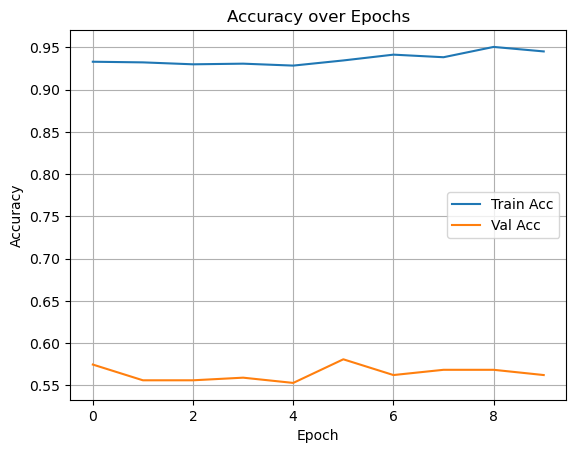

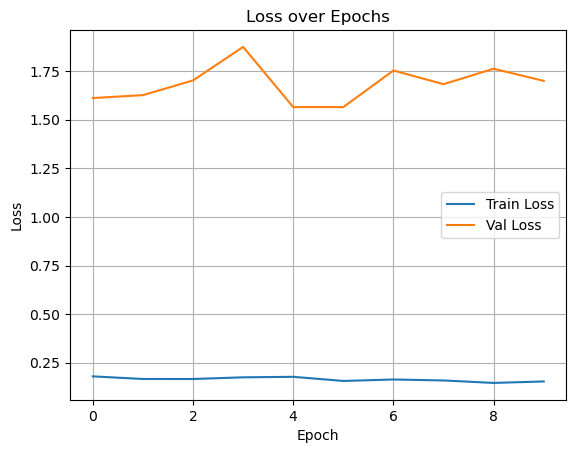

In [5]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
    # callbacks=[early_stop, checkpoint]
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

data_dir = 'C:/Users/Anne/OneDrive - National University of Ireland, Galway/Documents/Data Analytics/PROJECT/Capstone2025_Anne/kaggle/working/merged_images'  # Update with the dataset path

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import numpy as np

def try_model_vgg16():
    # Load the base model with VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
trymodel_vgg16 = try_model_vgg16()

# Compile the model
trymodel_vgg16.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


In [ ]:
# Train the model
history_V2 = trymodel_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=13,
    epochs=7
)

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation loss
plt.plot(history_V2.history['val_loss'], label='Validation Loss')
plt.plot(history_V2.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_V2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_V2.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Save the third model (v3) to a file
trymodel_vgg16.save('model_vgg16.keras')

# Optionally, load the model back to verify
trymodel_vgg16 = load_model('model_vgg16.keras')


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# --- Load model ---
model = tf.keras.models.load_model("Resnet50_v3.keras")  # <- Update path

# --- Base directory ---
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"

# --- Parameters ---
img_size = (224, 224)
num_samples = 12

# --- OPTIONAL: Uncomment for reproducible results
# random.seed(42)

# --- Collect image paths and labels ---
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder_path = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(int(label_folder))

# --- Random sample ---
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# --- Preprocessing + Prediction ---
def preprocess(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

predictions = []
original_imgs = []

for img_path in sample_paths:
    input_arr, orig = preprocess(img_path)
    pred = model.predict(input_arr, verbose=0)[0][0]
    predictions.append(pred)
    original_imgs.append(orig)

# --- Plotting ---
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(original_imgs[i])
    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
